## Model Training

In [1]:
# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import joblib


In [2]:
# Step 2: Load Dataset
df = pd.read_csv("ai4i2020.csv")  # adjust path as needed
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## Exploratory Data Analysis

In [3]:
df.info()
df.describe()
df['Type'].value_counts()
df["Target"] = df['Machine failure']
df['Target'].value_counts() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

Target
0    9661
1     339
Name: count, dtype: int64

🔍 Inference:
No missing values detected.

Data types are mostly numeric, with 'Type' being a categorical feature.

Some features (e.g., Tool wear and Torque) show a wide range, indicating possible outliers.

The dataset is clean and ready for preprocessing.

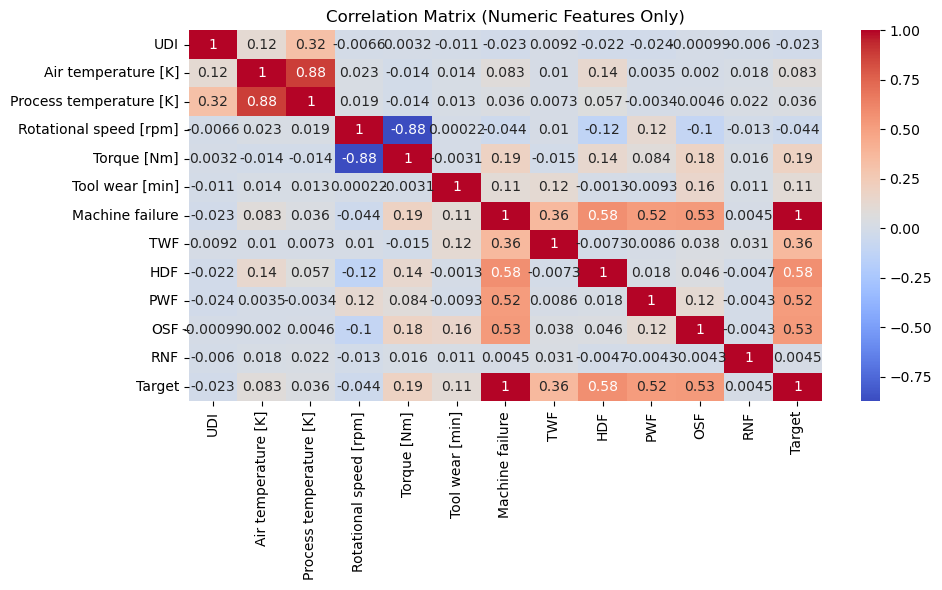

In [4]:
# Plot correlations
# Filter only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Numeric Features Only)")
plt.tight_layout()
plt.show()


# 🔍 Inference:
Air temperature and process temperature are positively correlated (makes sense).

Torque and rotational speed show a slight inverse correlation.

None of the features are too highly correlated (no multicollinearity concerns).



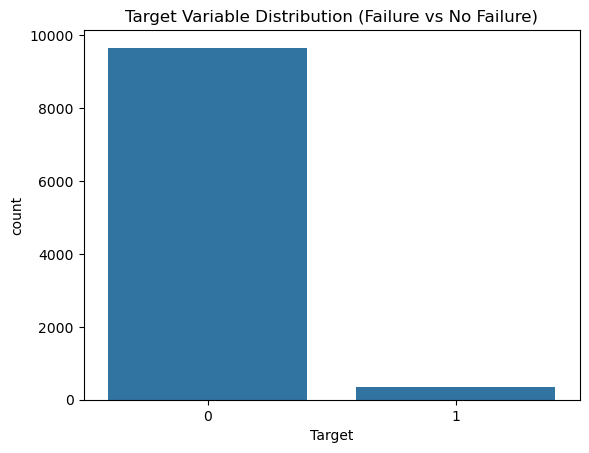

In [5]:
# Visualizing target distribution
sns.countplot(x='Target', data=df)
plt.title("Target Variable Distribution (Failure vs No Failure)")
plt.show()


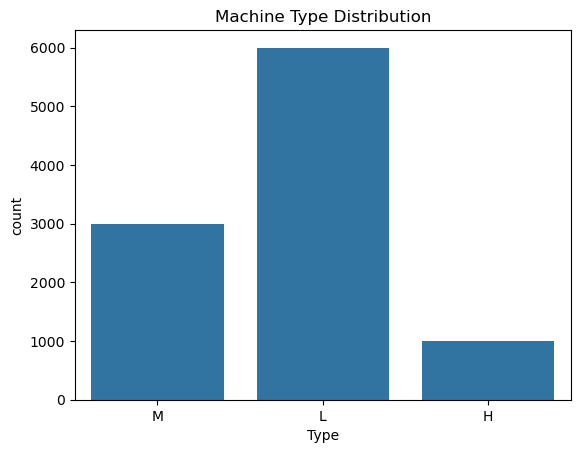

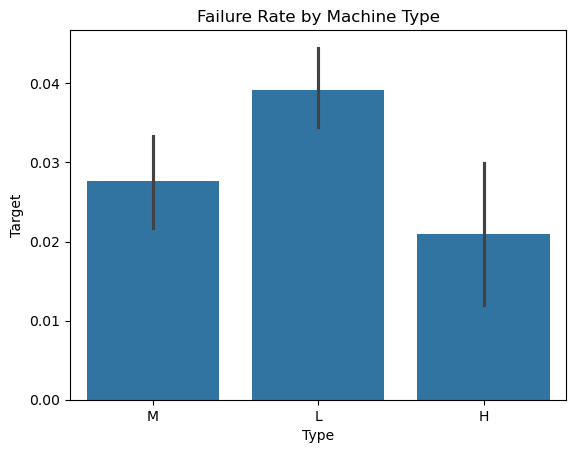

In [6]:
# Count by machine type :- means what type of machine is more into failures
sns.countplot(x='Type', data=df)
plt.title("Machine Type Distribution")
plt.show()

# Compare failure rate across types
sns.barplot(x='Type', y='Target', data=df)
plt.title("Failure Rate by Machine Type")
plt.show()


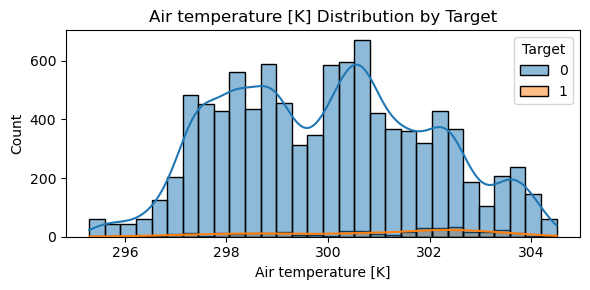

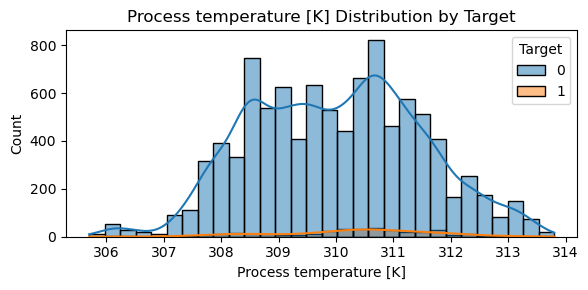

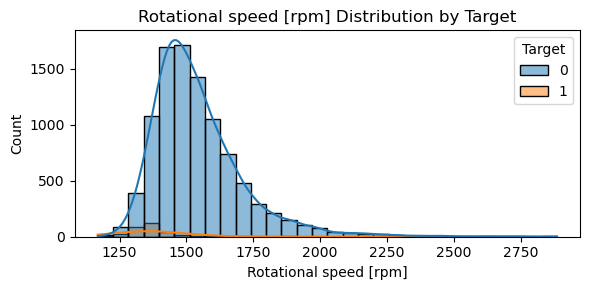

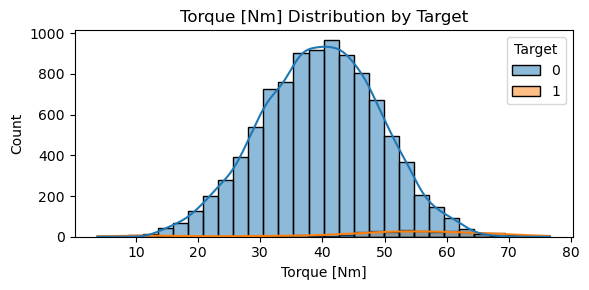

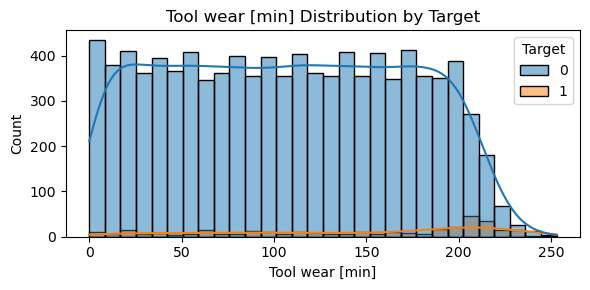

In [7]:
cols = ['Air temperature [K]', 'Process temperature [K]', 
        'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

for col in cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(data=df, x=col, hue='Target', kde=True, bins=30)
    plt.title(f"{col} Distribution by Target")
    plt.tight_layout()
    plt.show()


🔍 Inference:
Failed machines tend to show:

Higher torque

More tool wear

Slightly different air & process temperatures

Some sensor values differ significantly between failure and non-failure classes — they’re likely informative features.

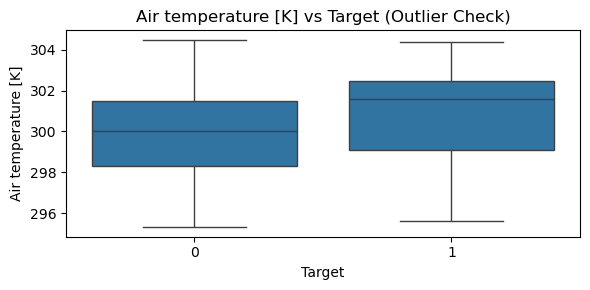

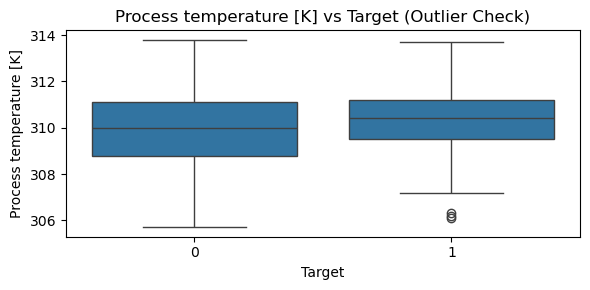

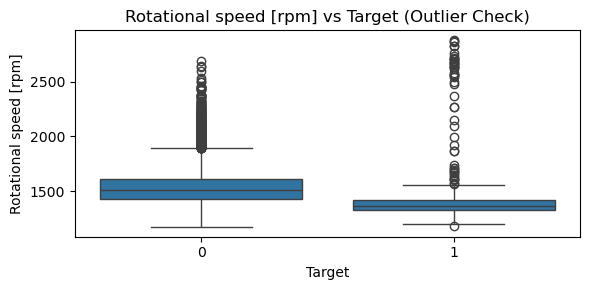

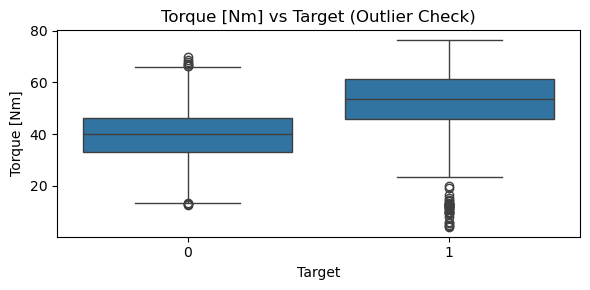

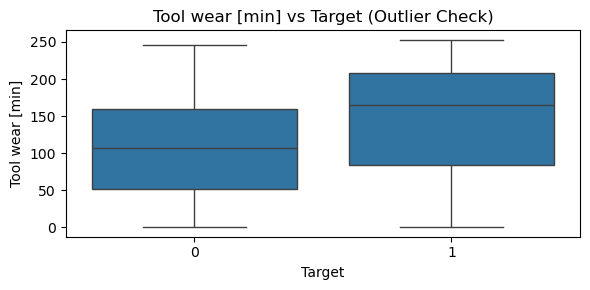

In [8]:
for col in cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='Target', y=col, data=df)
    plt.title(f"{col} vs Target (Outlier Check)")
    plt.tight_layout()
    plt.show()


🔍 Inference:
Several features show extreme values (especially tool wear and torque) for failed equipment.

These are likely early warning signs of equipment stress or degradation.

No need to remove them — they’re probably meaningful rather than bad data.

## Pre Processing

In [9]:
# Encode categorical Feature
df['Type'] = df['Type'].map({'L': 0, 'M': 1, 'H': 2})


In [10]:
#Dividing features and target
features = ['Type', 'Air temperature [K]', 'Process temperature [K]',
            'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

target = 'Target'

X = df[features]
y = df[target]


In [11]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


scaling because features like Torque and Tool wear are on very different scales — and models like logistic regression and KNN are sensitive to this.

## Train_Test_Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [13]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42)  # you can also tune hyperparameters later
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)





class_weight='balanced' helps deal with class imbalance by penalizing the majority class.



In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = xgb_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.87      0.69      0.77        68

    accuracy                           0.99      2000
   macro avg       0.93      0.84      0.88      2000
weighted avg       0.99      0.99      0.99      2000

Accuracy: 0.986


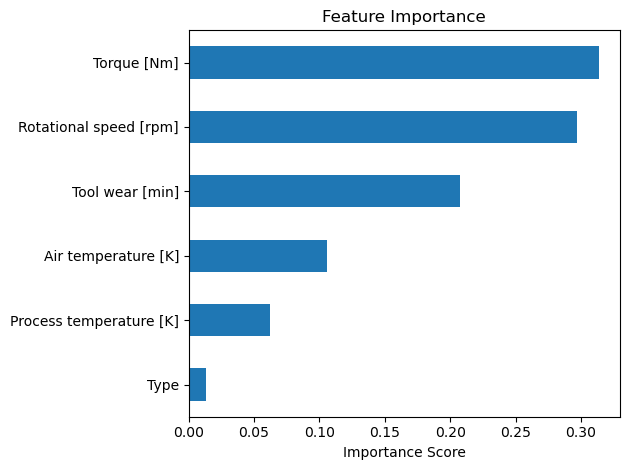

In [ ]:
import pandas as pd

feature_importance = pd.Series(model.feature_importances_, index=features)
feature_importance.sort_values().plot(kind='barh', title='Feature Importance')
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


#### As i got 98% accuracy, i am trying for more classifiers and comparing all of them.

# Model Comparison Function

In [19]:
!pip install xgboost

c:\Users\DELL\anaconda3\anaconda2\envs\pred_maint_env\lib\site-packages\xgboost\training.py:183: UserWarning: [18:23:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


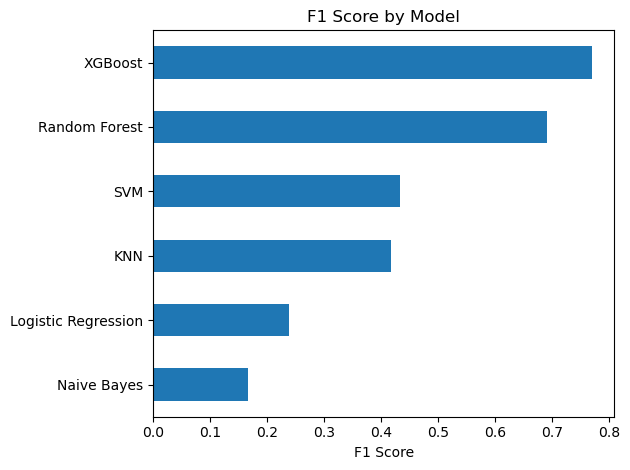

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

results = {}

for name, xgb_model in models.items():
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    results[name] = f1
    #print(f"\n{name}")
    #print(classification_report(y_test, y_pred)) #This will print about model accuracy,f1 score etc.

# Plot F1 scores
pd.Series(results).sort_values().plot(kind='barh', title='F1 Score by Model')
plt.xlabel("F1 Score")
plt.tight_layout()
plt.show()


In [ ]:
#Store results
results = []

for name, xgb_model in models.items():
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": round(acc * 100, 2)})

# Display results in table
accuracy_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
print(accuracy_df)

c:\Users\DELL\anaconda3\anaconda2\envs\pred_maint_env\lib\site-packages\xgboost\training.py:183: UserWarning: [18:23:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy
0              XGBoost     98.60
1        Random Forest     98.20
2                  KNN     97.35
3          Naive Bayes     96.00
4                  SVM     92.00
5  Logistic Regression     82.05


C:\Users\DELL\AppData\Local\Temp\ipykernel_12496\1113422435.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accuracy_df, x="Accuracy", y="Model", palette="viridis")


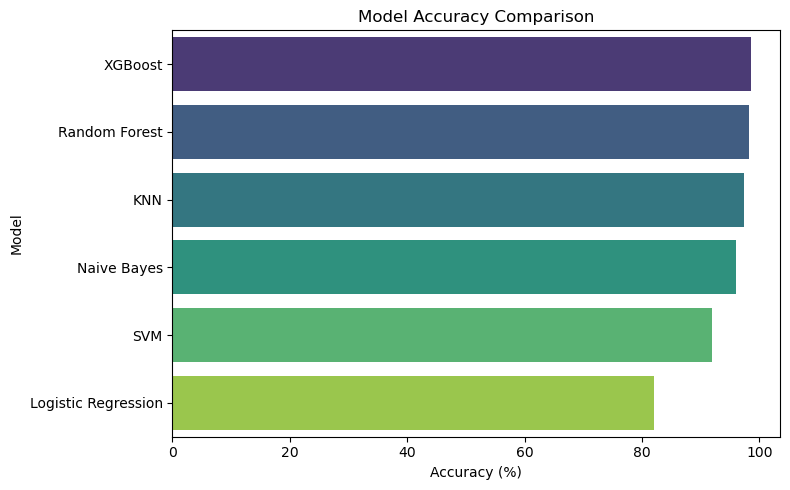

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=accuracy_df, x="Accuracy", y="Model", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy (%)")
plt.tight_layout()
plt.show()


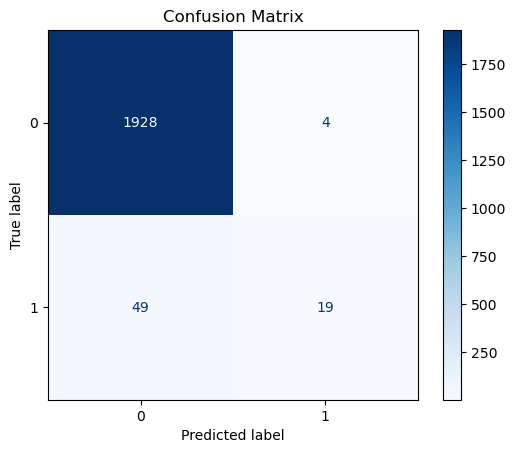

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)

disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [18]:
import joblib

joblib.dump(xgb_model, '../model/model.pkl')
joblib.dump(scaler, '../model/scaler.pkl')


['../model/scaler.pkl']

In [ ]:
xgb_mode

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)